In [117]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [118]:
data = pd.read_csv('nba-player-stats-2021.csv', encoding='ISO-8859-1')
data.head()

,player,pos,age,tm,g,gs,mp,fg,fga,fgpercent,...,drb,trb,ast,stl,blk,tov,pf,pts,ortg,drtg
0,Precious Achiuwa,C,22,TOR,73,28,1725,7.7,17.5,0.439,...,9.5,13.7,2.4,1.1,1.2,2.4,4.4,19.2,105.0,110
1,Steven Adams,C,28,MEM,76,75,1999,5.0,9.2,0.547,...,9.8,18.2,6.1,1.6,1.4,2.8,3.7,12.6,125.0,108
2,Bam Adebayo,C,24,MIA,56,56,1825,11.1,20.0,0.557,...,11.7,15.5,5.2,2.2,1.2,4.1,4.7,29.3,117.0,104
3,Santi Aldama,PF,21,MEM,32,0,360,7.0,17.5,0.402,...,7.2,11.6,2.8,0.8,1.3,2.1,4.8,17.5,101.0,111
4,LaMarcus Aldridge,C,36,BRK,47,12,1050,11.6,21.1,0.550,...,8.5,11.9,1.9,0.6,2.2,2.0,3.6,28.0,119.0,112


In [119]:
data = data.rename(columns={'player':'Player', 'pos':'Position', 'age':'Age', 'tm':'Team', 'g':'N_Games', 
                            'gs':'Game_Started', 'mp':'Minute_played', 'fg':'Field_goal', 'fga':'Goal_attempt', 
                            'fgpercent':'Field_goal%',
                            'x3p':'3points_scored', 'x3pa':'3points_Assists', 'x3ppercent':'3points%', 'x2p':'2points_scored', 
                            'x2pa':'2points_assits',
                            'x2ppercent':'2points%', 'ft':'FreeThrow', 'fta':'FreeThrowAttempt',
                            'ftpercent':'FreeThrow%', 'orb':'OffensiveRebound', 'drb':'DenffesiveRebound', 'trb':'TotalRebound', 
                            'ast':'Assists', 'stl':'Steal', 'blk':'Blocks', 'tov':'TurnOver', 'pf':'PersonalFoul',
                            'pts':'Points', 'ortg':'OffensiveRating', 'drtg':'DeffensiveRating'})

### Basic understanding of data

In [120]:
print(data.describe())

              Age     N_Games  Game_Started  Minute_played  Field_goal  \
count  812.000000  812.000000    812.000000     812.000000  812.000000   
mean    26.051724   36.705665     16.672414     825.188424    6.935468   
std      4.059640   25.898042     23.817195     775.786331    3.419585   
min     19.000000    1.000000      0.000000       1.000000    0.000000   
25%     23.000000   12.000000      0.000000     121.000000    5.100000   
50%     25.000000   36.500000      4.000000     577.500000    6.850000   
75%     29.000000   61.000000     25.000000    1414.500000    8.600000   
max     41.000000   82.000000     82.000000    2854.000000   49.000000   

       Goal_attempt  Field_goal%  3points_scored  3points_Assists    3points%  \
count    812.000000   797.000000      812.000000       812.000000  740.000000   
mean      16.066995     0.434257        2.028695         6.467611    0.303445   
std        5.627889     0.137794        1.573494         4.443072    0.138111   
min      

In [121]:
print(f'Duplicate entries: {data.duplicated().sum()} \nNull values: \n{data.isna().sum()}')

Duplicate entries: 0 
Null values: 
Player                0
Position              0
Age                   0
Team                  0
N_Games               0
Game_Started          0
Minute_played         0
Field_goal            0
Goal_attempt          0
Field_goal%          15
3points_scored        0
3points_Assists       0
3points%             72
2points_scored        0
2points_assits        0
2points%             28
FreeThrow             0
FreeThrowAttempt      0
FreeThrow%           97
OffensiveRebound      0
DenffesiveRebound     0
TotalRebound          0
Assists               0
Steal                 0
Blocks                0
TurnOver              0
PersonalFoul          0
Points                0
OffensiveRating      10
DeffensiveRating      0
dtype: int64


In [122]:
data.shape

(812, 30)

In [123]:
# Drop all row with duplicate players
data = data.drop_duplicates(subset=['Player'])
data.shape

(605, 30)

In [124]:
# Fill all missing data with the most frequent rather than droping them since this is a small dataset
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)

## Exploratory Data Analysis (EDA)

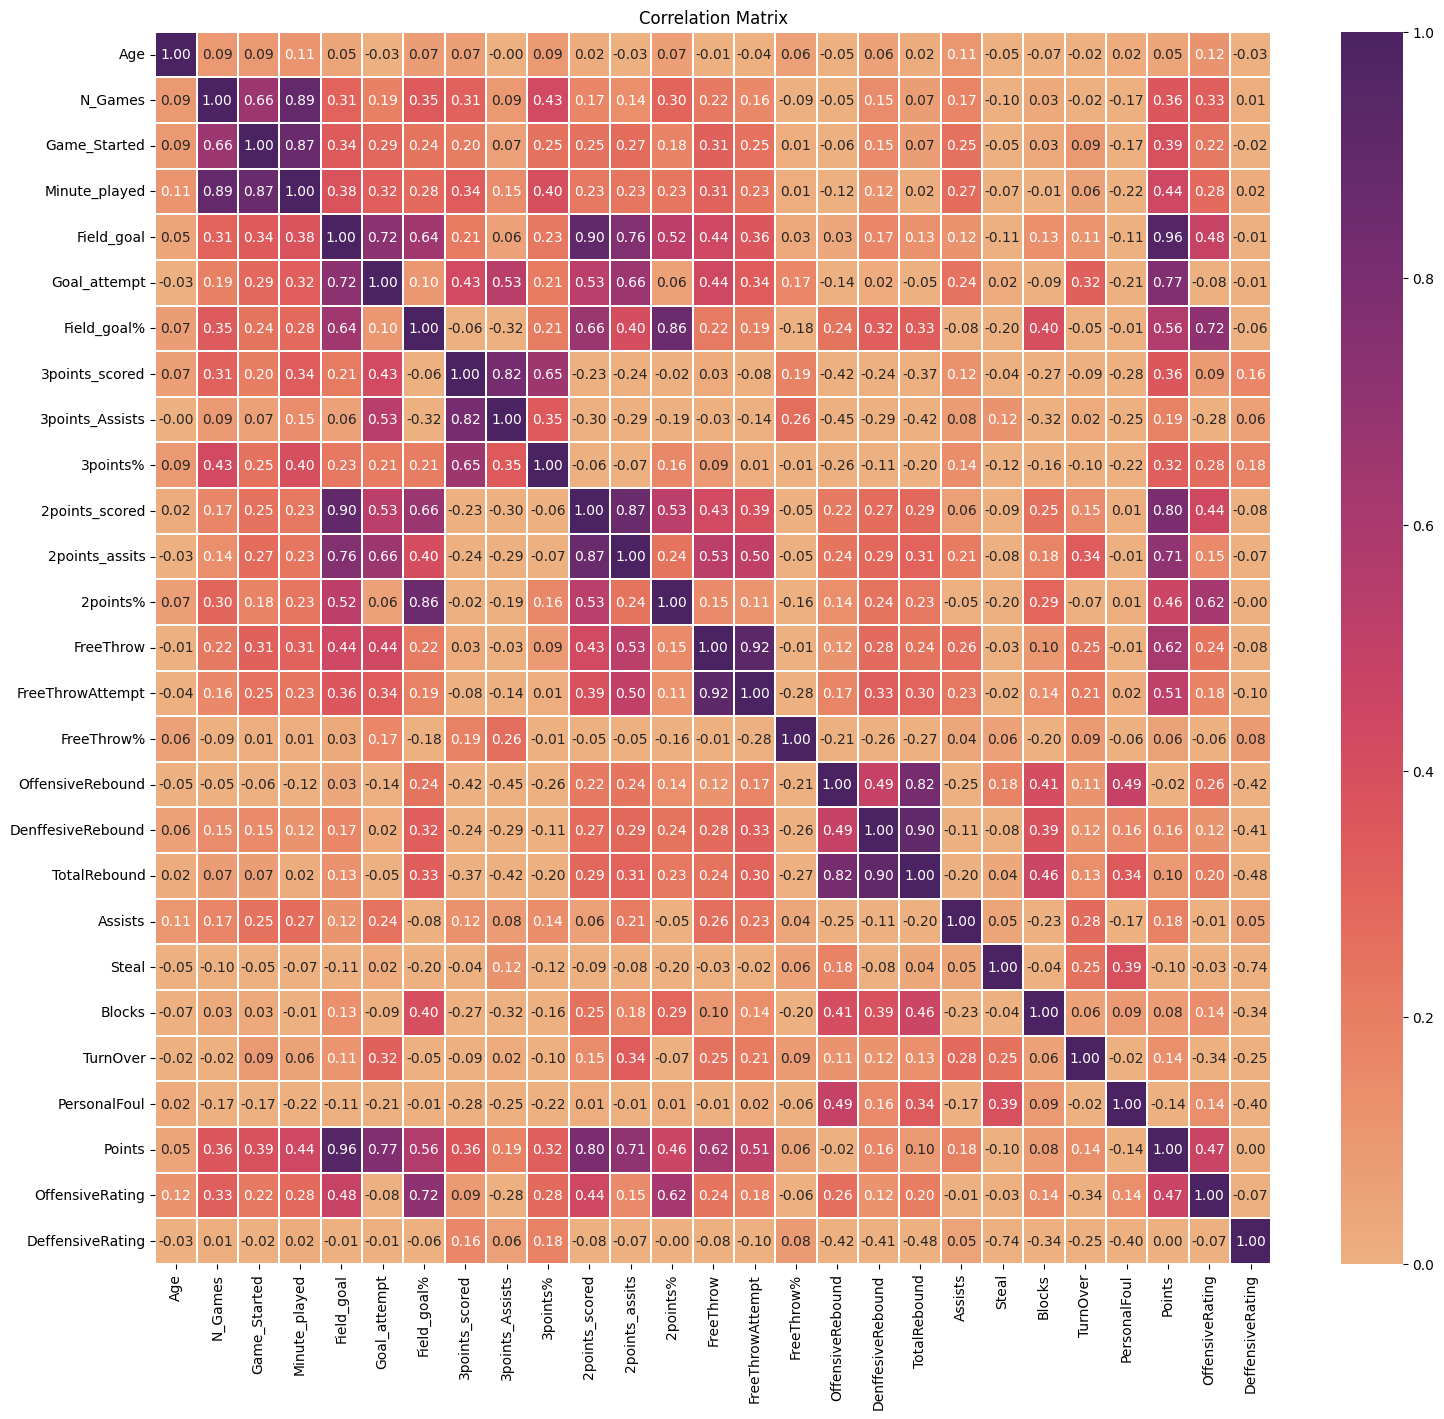

In [125]:
# Create a heatmap to see how our feature are interacting with one another

plt.figure(figsize=(18,16))
corr = data.drop(columns=['Player', 'Position', 'Team']).corr(method='pearson')
sns.heatmap(corr, annot=True, linewidth=.1, vmin=0, vmax=1,
            fmt=".2f", cmap=sns.color_palette("flare", as_cmap=True))
plt.title('Correlation Matrix')
plt.show()

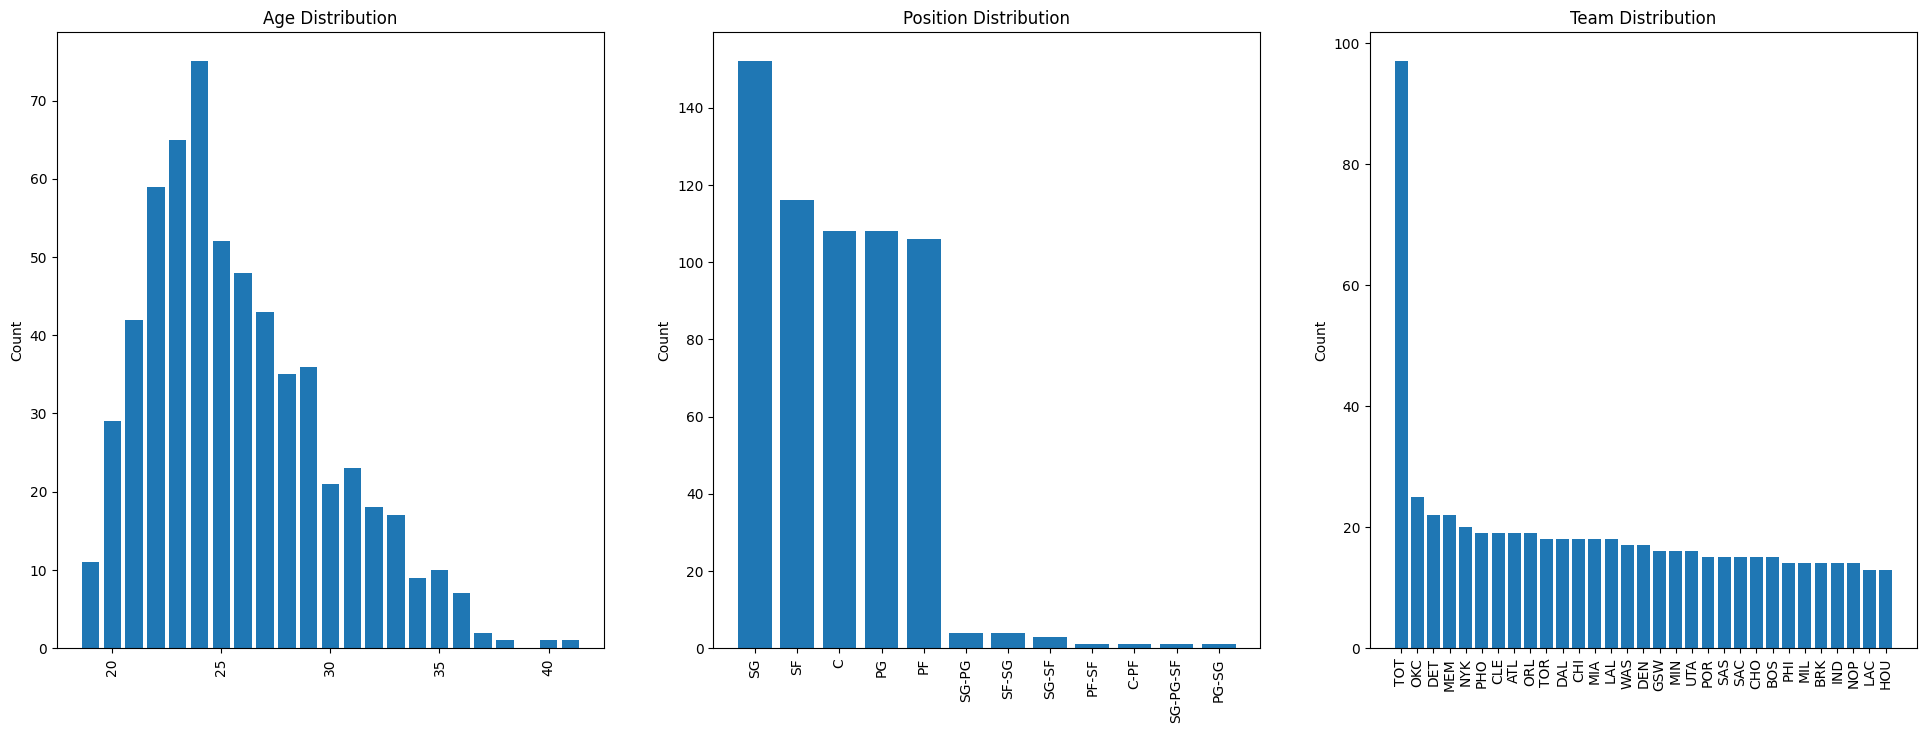

In [126]:
# Create a figure and subplots to plot all categorical variable distribution
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
variables = ['Age', 'Position', 'Team']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values)
    ax.set_title(f'{var.capitalize()} Distribution')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)

In [127]:
y = data['Position']

# Remove all lower classes in our target variable
class_count = y.value_counts()
rare_class = [cls for cls, count in class_count.items() if count <=4]
new_class_indice = [i for i, label in enumerate(y) if label not in rare_class]

data = data.iloc[new_class_indice]

## Feature Engineering

In [128]:
# create some feature engineering
data['Avg_Rating'] = (data['OffensiveRating'] + data['DeffensiveRating'])/2
data['Avg_Rebound'] = (data['OffensiveRebound'] + data['DenffesiveRebound'])/2

# Drop features that are not relevent to our study
data = data.drop(columns=['Team'])

##### Identify and Remove outliers

/var/folders/sb/73j4d15s4k34y66s1tpvsgx80000gn/T/ipykernel_13439/806505450.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


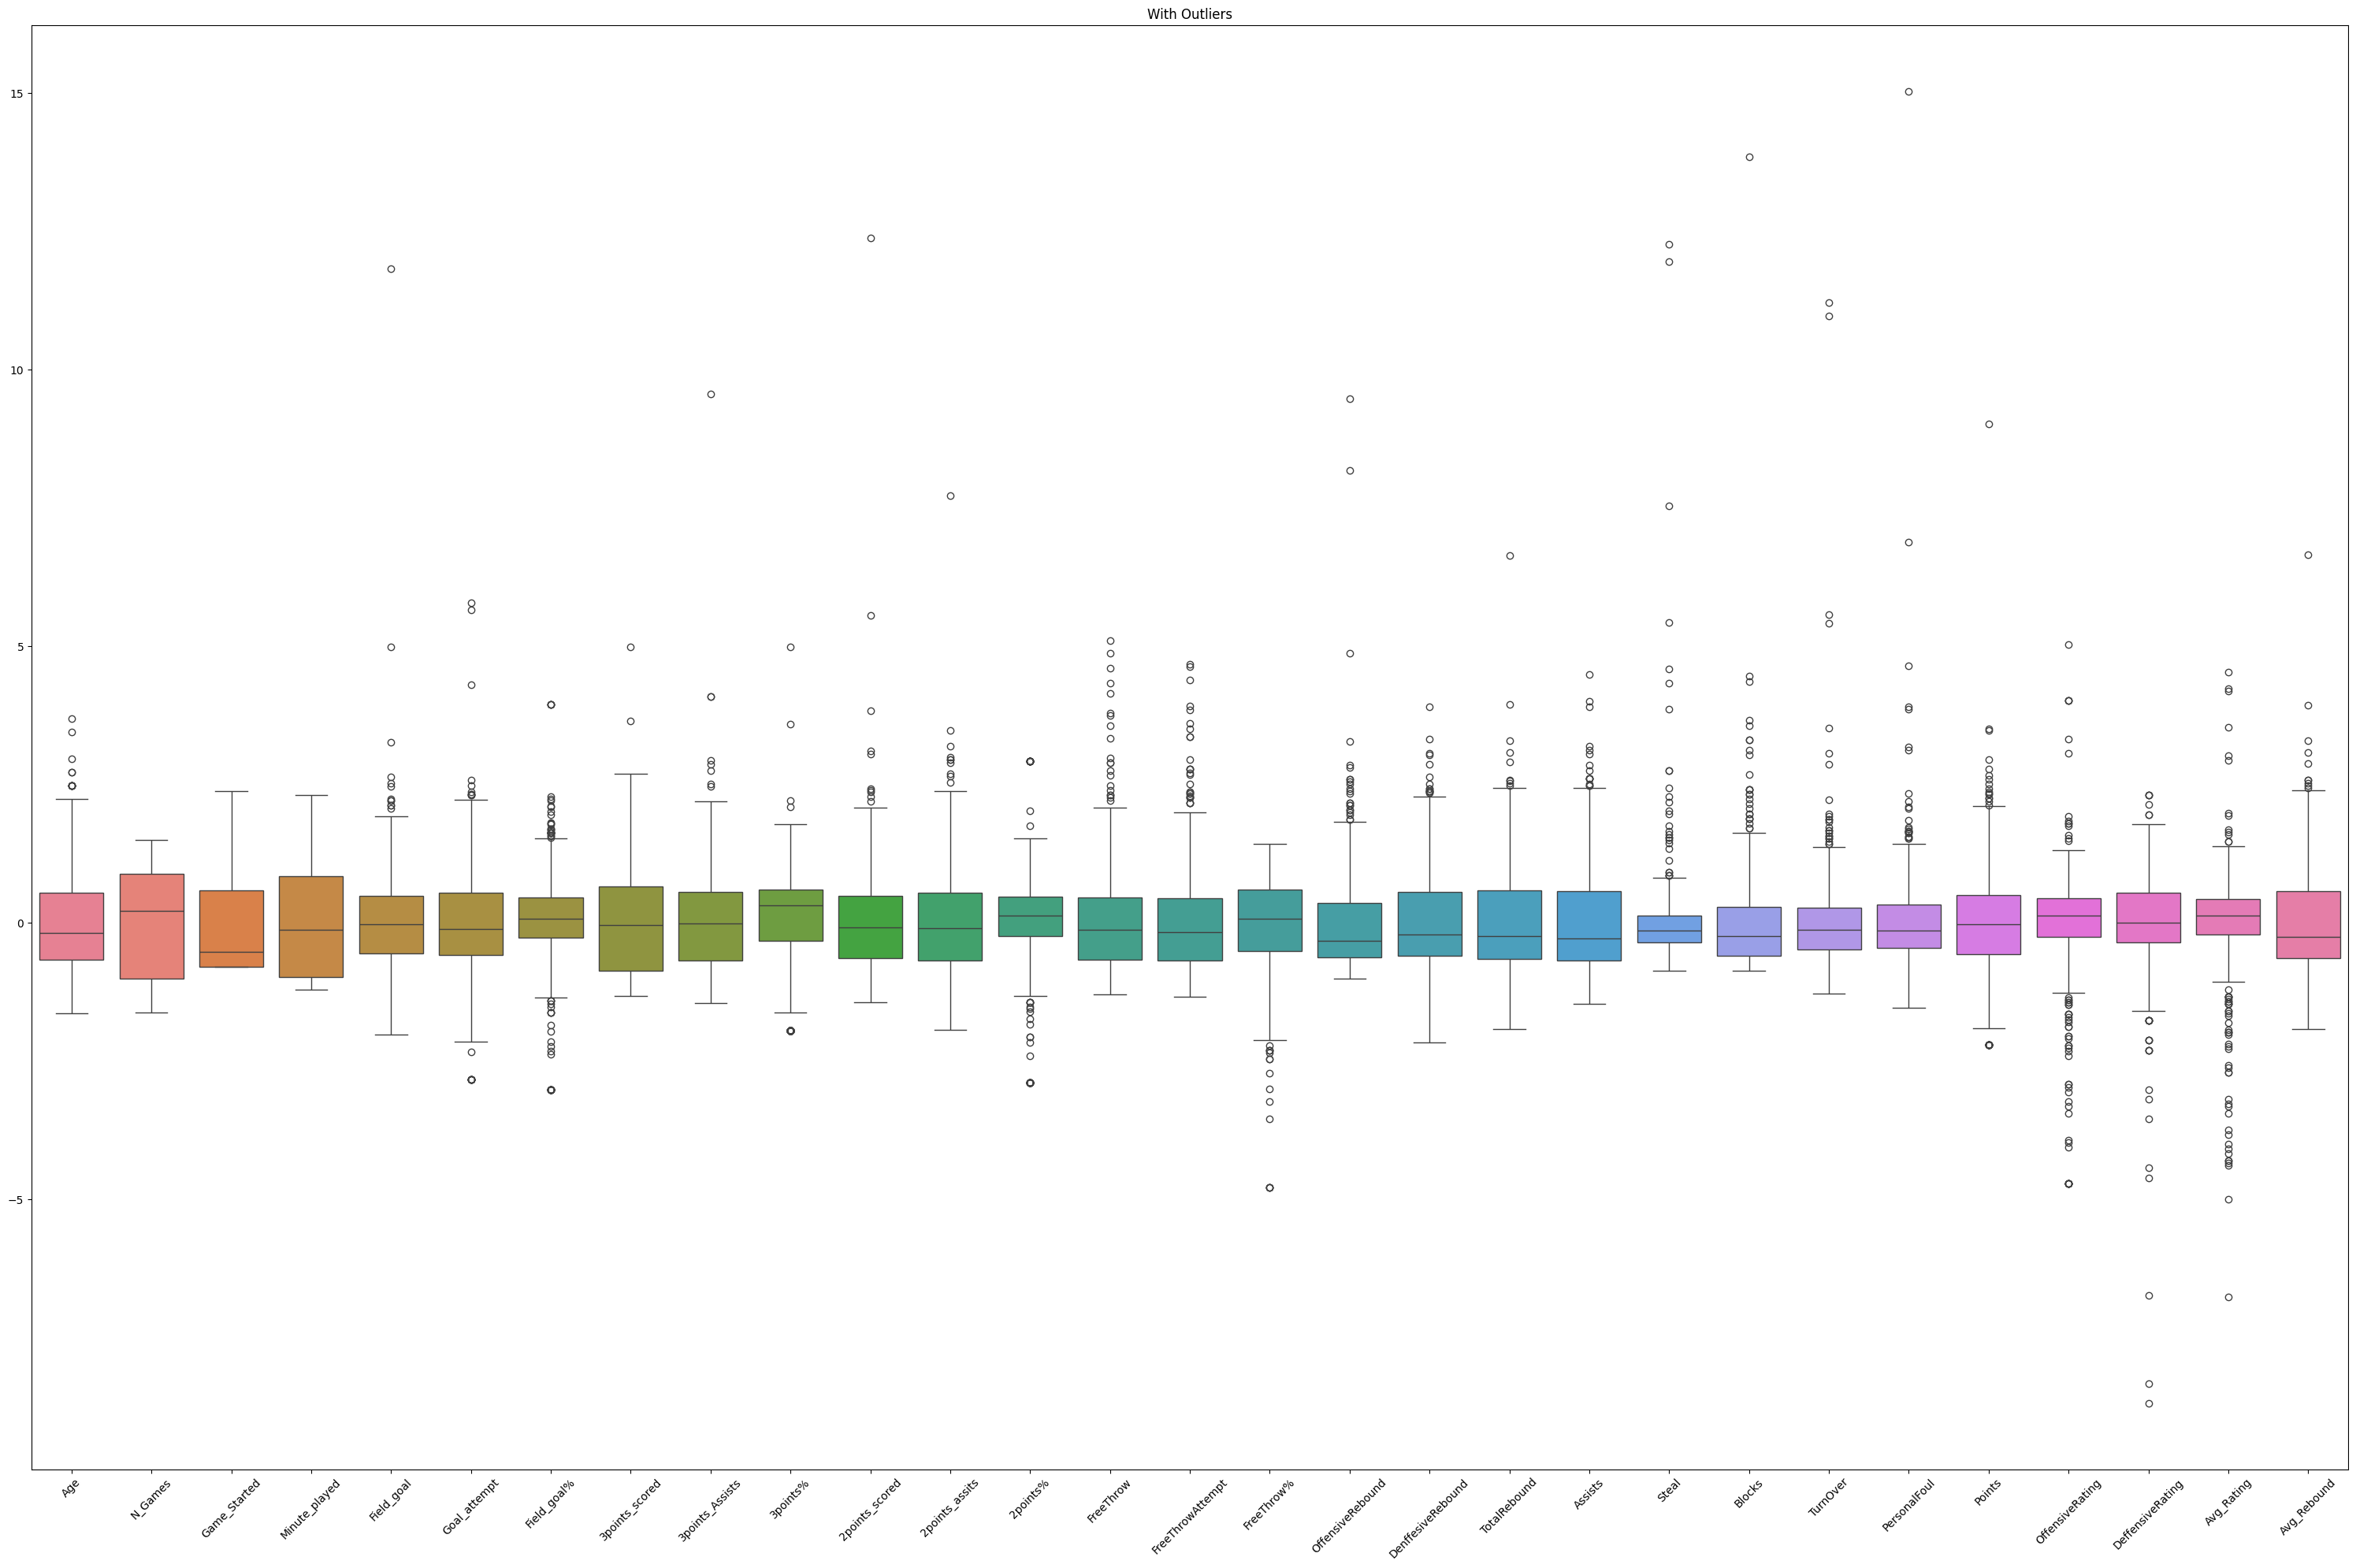

In [129]:
# Get all the numerical columns and scale them
features = [col for col in data.columns if col not in ['Position', 'Player','Age_Binned']]
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Plot Boxplot
fig, ax = plt.subplots(figsize=(30,20))
sns.boxplot(data=scaled_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('With Outliers')
plt.tight_layout()
plt.show()

/var/folders/sb/73j4d15s4k34y66s1tpvsgx80000gn/T/ipykernel_13439/2772015398.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


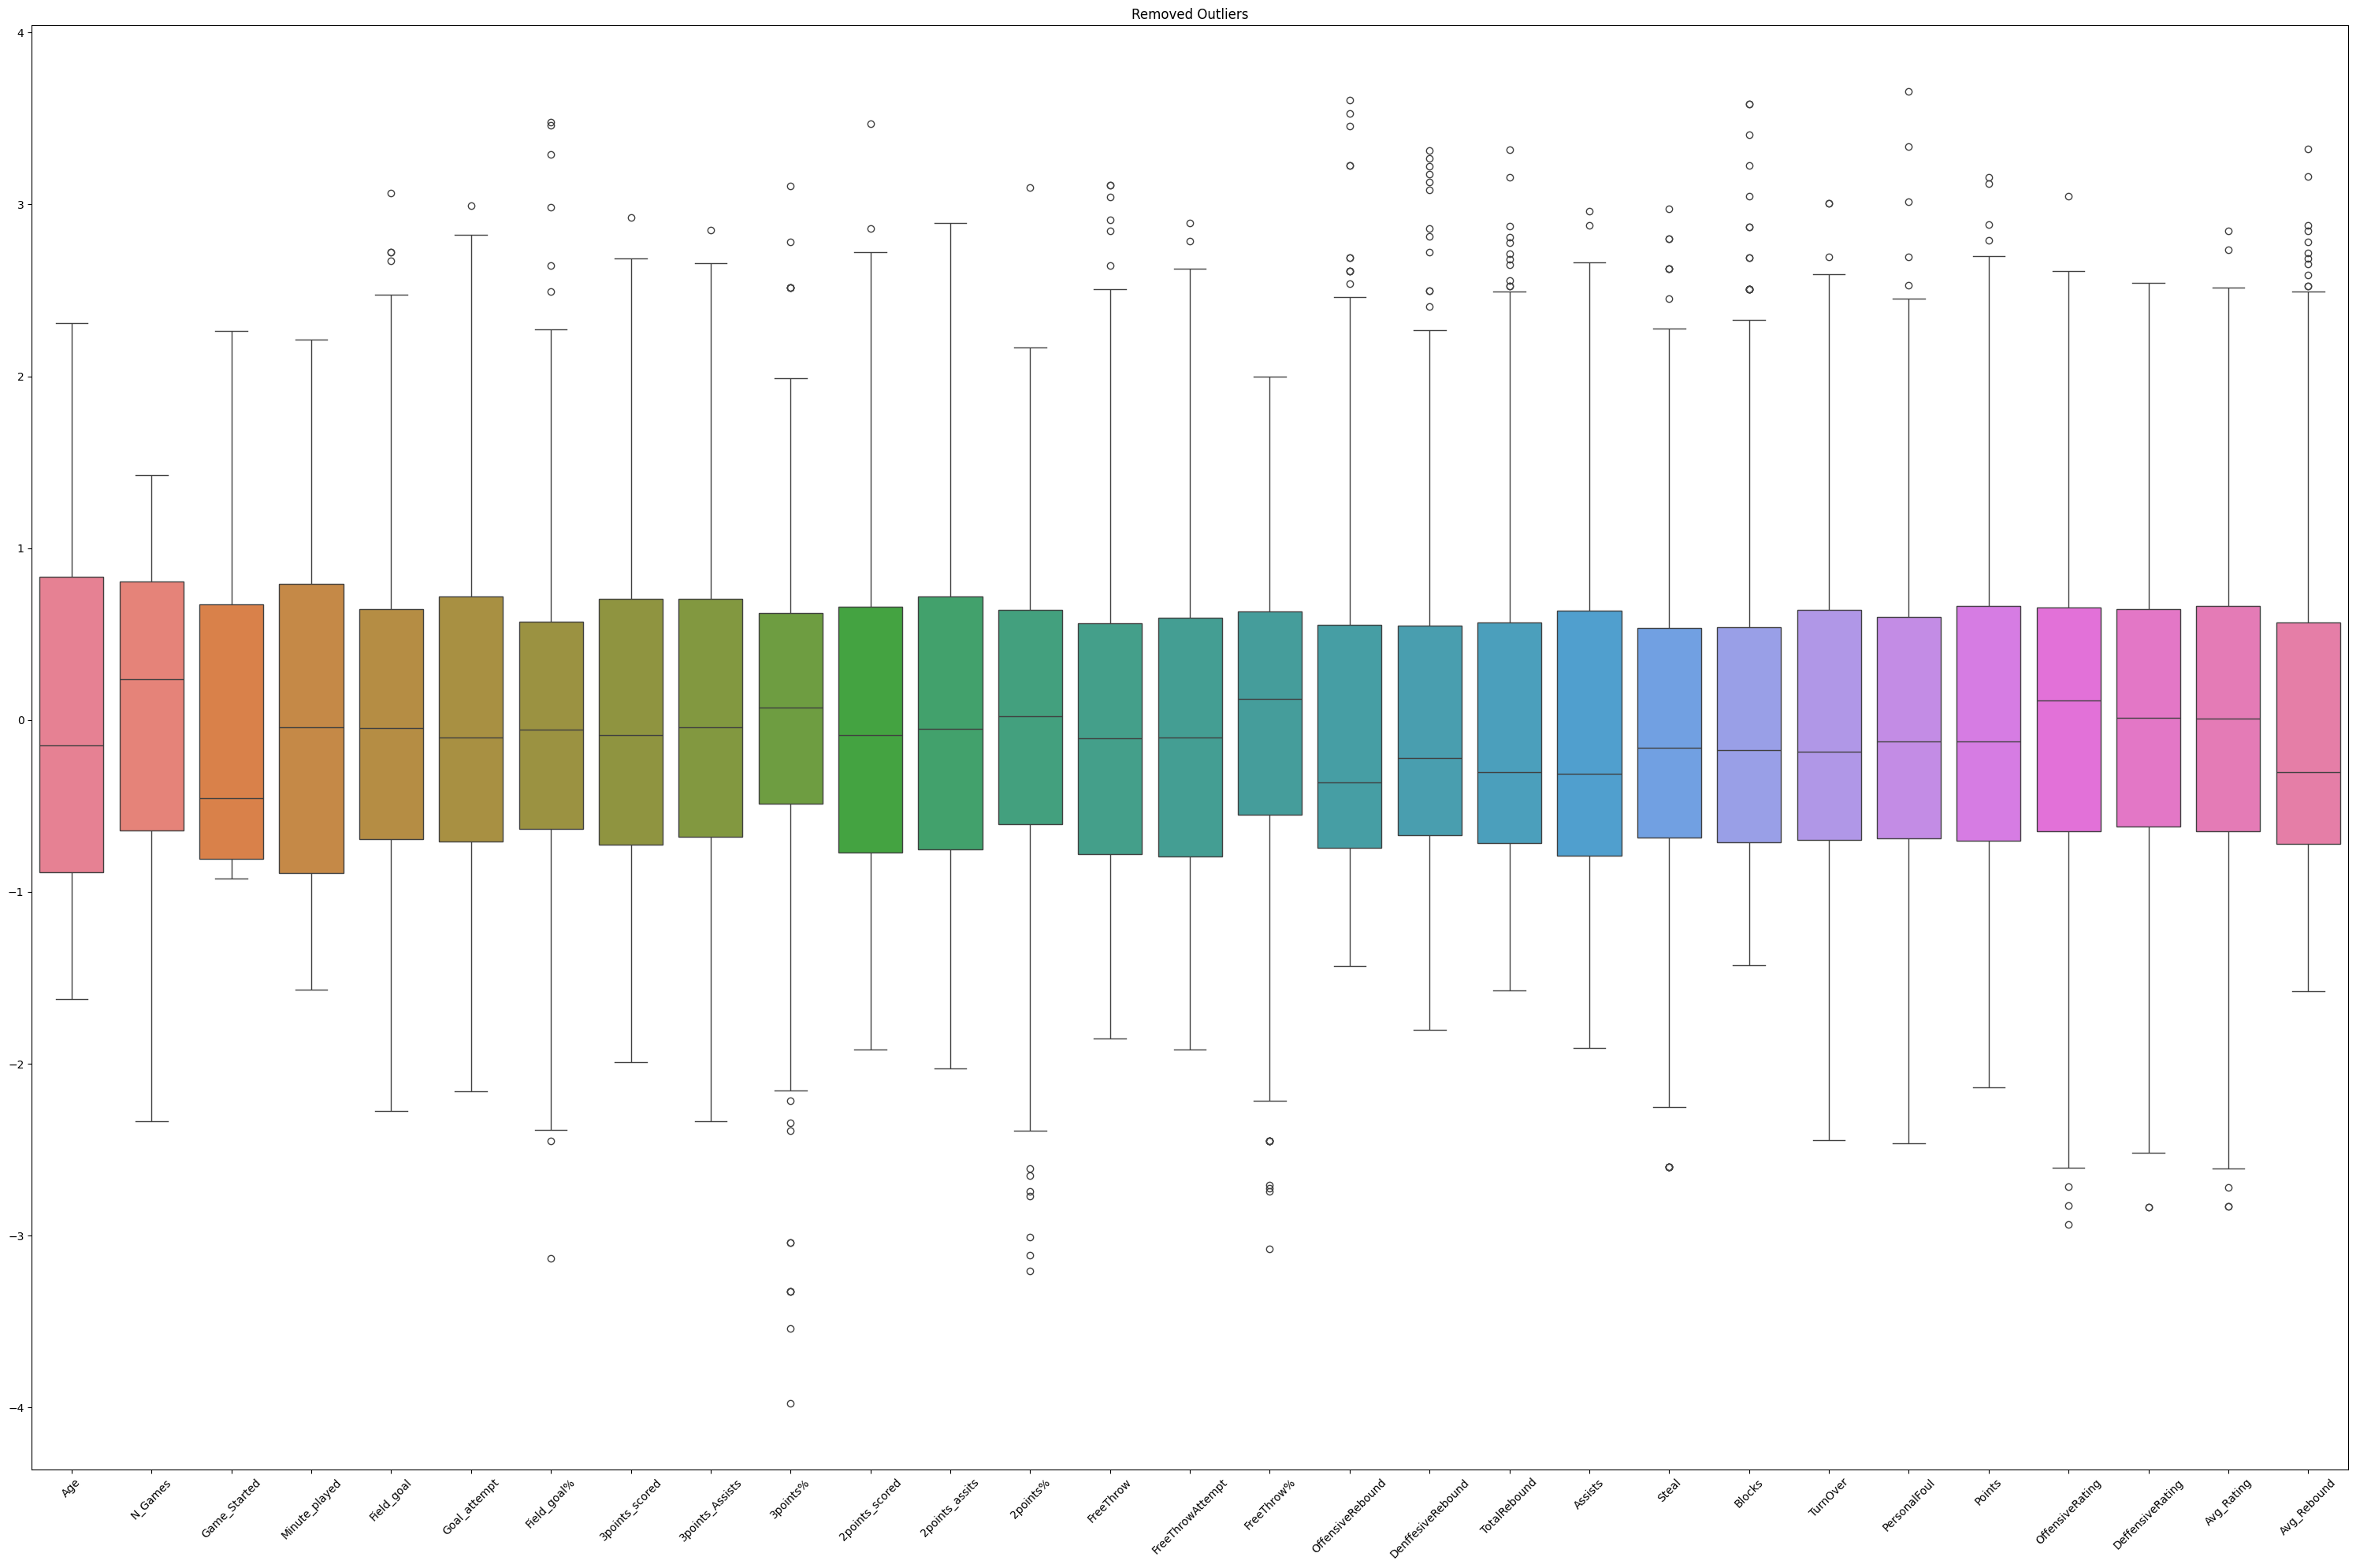

In [130]:
# Calculate outliers
Q1 = scaled_data.quantile(0.25)
Q3 = scaled_data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers and mask it to the original data
mask = ~((scaled_data < lower_bound) | (scaled_data > upper_bound)).any(axis=1)
filtered_data = data[mask].copy()

# scale the data and put on the dataframe to make easy to visualize
filtered_scaled_data = pd.DataFrame(scaler.fit_transform(filtered_data[features]), columns=features, index=filtered_data.index)

# boxplot
fig, ax = plt.subplots(figsize=(30,20))
sns.boxplot(data=filtered_scaled_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('Removed Outliers')
plt.tight_layout()
plt.show()

#### Feature importance for classification

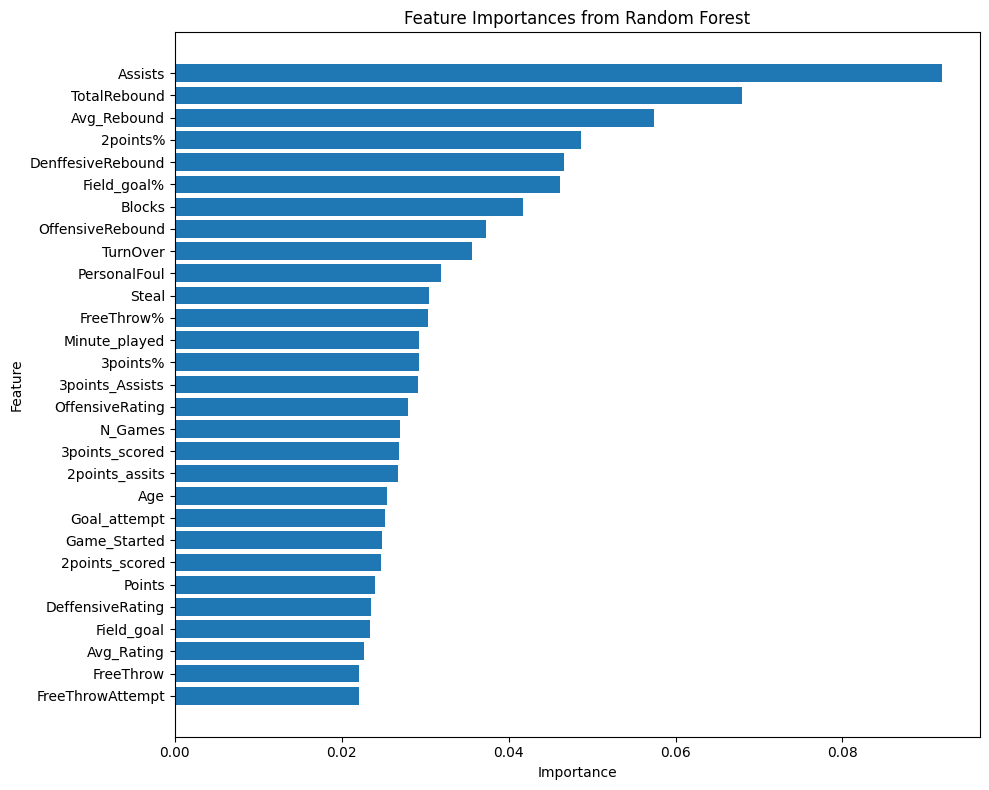

In [131]:
# create feature and target variables
X = filtered_data.drop(columns=['Position', 'Player'])
y = filtered_data['Position']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciate and fit model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create a DataFrame for feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,8))
plt.barh(importances['Feature'], importances['Importance'] )
plt.title("Feature Importances from Random Forest")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Model Training Test and Validation with Original Dataset

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best Score: 0.5627863247863248
Best Parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
              precision    recall  f1-score   support

           C       0.62      0.83      0.71        12
          PF       0.53      0.45      0.49        20
          PG       0.63      0.59      0.61        29
          SF       0.40      0.38      0.39        26
          SG       0.48      0.52      0.50        31

    accuracy                           0.53       118
   macro avg       0.53      0.55      0.54       118
weighted avg       0.52      0.53      0.52       118

---------------------------------------------------------------------------


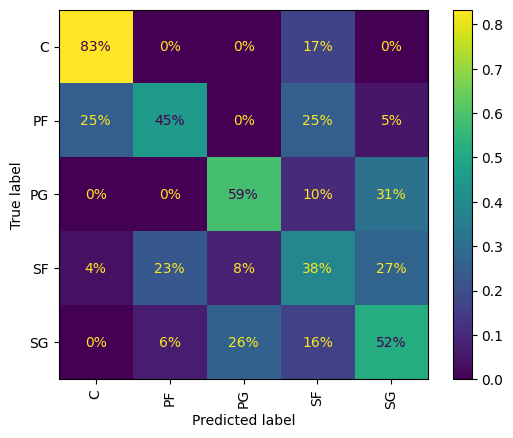

In [132]:
X = data.drop(columns = ['Position', 'Player'])
y = data['Position']

# Split the data before any preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create pipelines for each classifier to eliminate data leakage 
svc_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(class_weight='balanced', random_state=42))
])

# Define hyperparameters
params =[
    {
        'svc__kernel': ['linear', 'rbf', 'sigmoid'],
        'svc__C': [1, 10, 100],
        'svc__gamma': [0.1, 0.01, 0.001]
    }]

# Define different KFold strategies
fold = StratifiedKFold(n_splits=10)

# Perform cross-validation and grid search
grid_best_model = GridSearchCV(estimator=svc_pipeline, param_grid=params, scoring='balanced_accuracy', n_jobs=1, 
                                cv=fold, verbose=1)

grid_best_model.fit(X_train, y_train)

y_pred = grid_best_model.predict(X_test)

print(f'Best Score: {grid_best_model.best_score_}')
print(f'Best Parameters: {grid_best_model.best_params_}')

metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format=".0%", xticks_rotation='vertical')
print(metrics.classification_report(y_test, y_pred))
print('-' * 75)

# More Feature Engineering

In [ ]:
# Interaction features
filtered_data['Points_per_Minute'] = filtered_data['Points'] / filtered_data['Minute_played']

# Polynomial features
filtered_data['Field_goal%_squared'] = filtered_data['Field_goal%'] ** 2
filtered_data['Avg_Rating_squared'] = filtered_data['Avg_Rating'] ** 2

# Cross Features
filtered_data['Cross_2points_scored_assist'] = filtered_data['2points_assits'] * filtered_data['2points_scored']
filtered_data['Cross_3points_scored_assist'] = filtered_data['3points_Assists'] * filtered_data['3points_scored']
filtered_data['Ratings'] = filtered_data['DeffensiveRating'] * filtered_data['OffensiveRating']

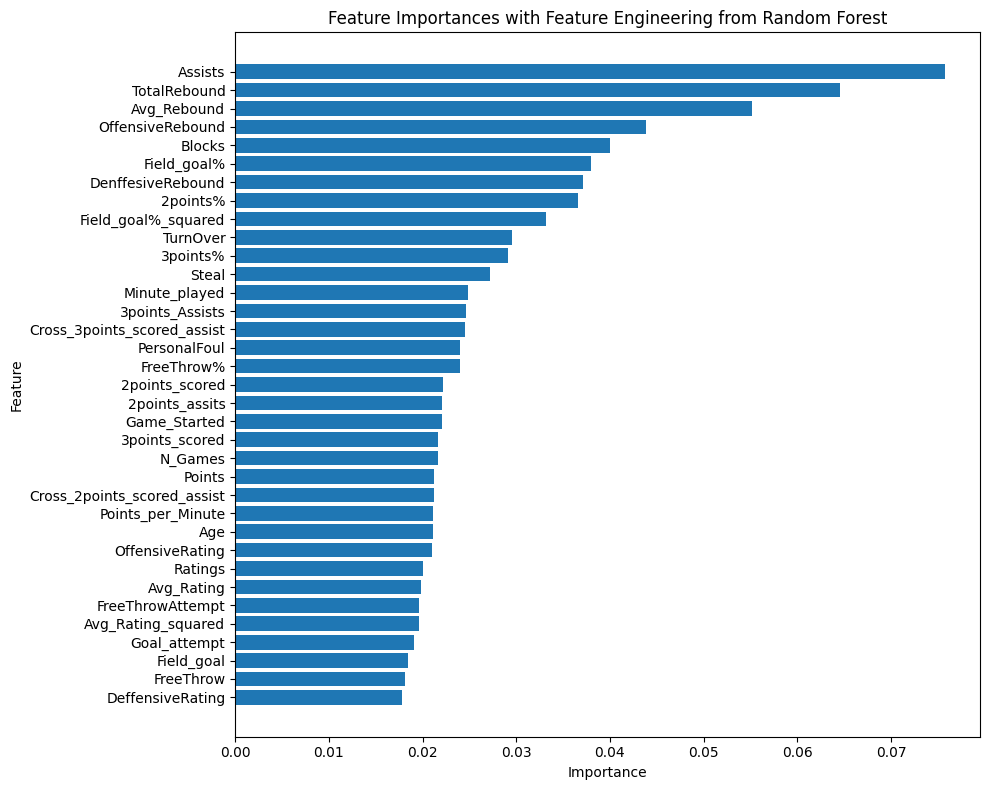

In [ ]:
# create feature and target variables
X = filtered_data.drop(columns=['Position', 'Player'])
y = filtered_data['Position']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciate and fit model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create a DataFrame for feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,8))
plt.barh(importances['Feature'], importances['Importance'] )
plt.title("Feature Importances with Feature Engineering from Random Forest")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# fill and NA values based on the feature engineering and reset the index
filtered_data = filtered_data.fillna(0)
filtered_data = filtered_data.reset_index(drop=True)

## Model Training, Test and Evaluation

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Score: 0.5685096385096385
Best Parameters: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid'}
              precision    recall  f1-score   support

           C       0.30      0.75      0.43         8
          PF       0.33      0.23      0.27        13
          PG       0.65      0.85      0.73        13
          SF       0.18      0.11      0.14        18
          SG       0.55      0.44      0.49        25

    accuracy                           0.43        77
   macro avg       0.40      0.48      0.41        77
weighted avg       0.42      0.43      0.41        77

---------------------------------------------------------------------------


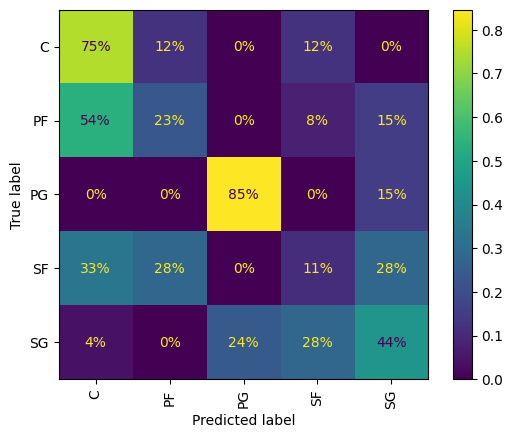

In [133]:
# Split features and target variables
top_features = importances['Feature'].head(10).values

X = filtered_data[top_features]
y = filtered_data['Position']

# Split the data before any preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create pipelines for each classifier to eliminate data leakage 
svc_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(class_weight='balanced', random_state=42))
])

# Define hyperparameters
params =[
    {
        'svc__kernel': ['linear', 'rbf', 'sigmoid'],
        'svc__C': [1, 10, 100],
        'svc__gamma': [0.1, 0.01, 0.001]
        
        }]

# Define different KFold strategies
fold = StratifiedKFold(n_splits=3)

grid_best_model = GridSearchCV(estimator=svc_pipeline, param_grid=params, scoring='balanced_accuracy', n_jobs=-1, 
                                cv=fold, verbose=1)

grid_best_model.fit(X_train, y_train)

y_pred = grid_best_model.predict(X_test)

print(f'Best Score: {grid_best_model.best_score_}')
print(f'Best Parameters: {grid_best_model.best_params_}')
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', values_format=".0%", xticks_rotation='vertical')
print(metrics.classification_report(y_test, y_pred))
print('-' * 75)

In [ ]:
# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(svc_pipeline, X_train, y_train, cv=5, n_jobs=-1)

# Calculate mean and standard deviation
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_std = test_scores.std(axis=1)

# Plot learning curves
plt.figure()
plt.title("Learning Curves (SVC)")
plt.xlabel("Train Size")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.grid()

plt.plot(train_sizes[1:], train_scores_mean[1:], 'o-', color="r", label="Training score")
plt.plot(train_sizes[1:], test_scores_mean[1:], 'o-', color="g", label="Testing score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")

plt.legend(loc="best")
plt.show()

# Sample test sets

In [135]:
# Create a sample dataset and put it on a DataFrame
data = {
    'Assists': [6.9, 2.9, 5.9],
    'TotalRebound': [19.7, 2.6, 6.0],
    'Avg_Rebound': [9.85, 1.80 , 3.15],
    '2points%': [0.788, 0.10, 0.3],
    'DenffesiveRebound': [9.5, 1.2, 5.1],
    'Field_goal%': [0.959, 0.12, 0.02],
    'Blocks': [9.2, 1.3, 0.8],
    'OffensiveRebound': [1.2, 4.4, 1.2],
    'TurnOver': [2.4, 9.1, 3.1],
    'PersonalFoul': [2.0, 9.0, 3.0]
}

test_set = pd.DataFrame(data)

# Predict labels for the new test data
y_testset_pred = grid_best_model.predict(test_set)

print(f'Predicted Labels are: {y_testset_pred}')

Predicted Labels are: ['C' 'SG' 'SG']


Projected output should be C, PG, SG